## Task 1: KNN

In [7]:
% matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.cm as cm

from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans, Birch, DBSCAN
from prettytable import PrettyTable
from scipy.spatial.distance import cdist
from sklearn import datasets

In [8]:
from scipy.stats import mode

def dist(a, b):
    return np.sqrt((np.square(a[:,np.newaxis] - b).sum(axis=2)))

def knn(train_X, train_Y, test_X, test_Y, ks):
    dists = dist(train_X, test_X)
    
    closest = np.argsort(dists, 0)
    targets = train_Y[closest]
    
    errs = np.zeros((len(ks),))
    
    for ki, k in enumerate(ks):
        predictions, _ = mode(targets[:k,:], axis=0)
        predictions = predictions.ravel()

        errs_cnt = 0
        for ix, pred in enumerate(predictions):
            if pred != test_Y[ix]:
                errs_cnt += 1

        errs[ki] += errs_cnt
        
    errs /= test_Y.shape    
    return np.vstack((ks, errs))

In [9]:
iris = datasets.load_iris()

[[  3.           5.           7.           9.          11.          13.
   15.          17.          19.        ]
 [  0.04081633   0.06122449   0.06122449   0.04081633   0.04081633
    0.04081633   0.06122449   0.06122449   0.06122449]]


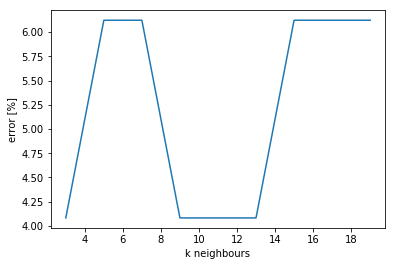

In [47]:
indxs = np.array(range(0, len(iris.data)))
np.random.shuffle(indxs)

ks = range(3,21, 2)
errs = knn(iris.data[indxs[:100]], iris.target[indxs[:100]],
           iris.data[indxs[100:150]], iris.target[indxs[100:150]], ks)
  
print(errs)
plt.plot(errs[0, :], errs[1, :] * 100.0) 
plt.ylabel('error [%]')
plt.xlabel('k neighbours')
plt.show()

In [43]:
import csv
def load_digits():
    data = np.genfromtxt('optdigits.tra', delimiter=',')
    labels = data[:, -1]
    X = data[:, :-1]
    return X, labels

digitsX, digitsY = load_digits()
print digitsX, digitsY, len(digitsY)

[[  0.   1.   6. ...,   1.   0.   0.]
 [  0.   0.  10. ...,   3.   0.   0.]
 [  0.   0.   8. ...,   0.   0.   0.]
 ..., 
 [  0.   0.   3. ...,   9.   0.   0.]
 [  0.   0.   6. ...,  16.   5.   0.]
 [  0.   0.   2. ...,   0.   0.   0.]] [ 0.  0.  7. ...,  6.  6.  7.] 3823


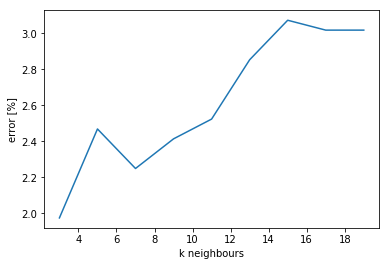

In [49]:
indxs = np.array(range(0, len(digitsX)))
np.random.shuffle(indxs)

ks = range(3,21, 2)
errs = knn(digitsX[indxs[:2000]], digitsY[indxs[:2000]],
           digitsX[indxs[2000:]], digitsY[indxs[2000:]], ks)

plt.plot(errs[0, :], errs[1, :] * 100.0) 
plt.ylabel('error [%]')
plt.xlabel('k neighbours')
plt.show()

In [75]:
def cross_valid(X, Y, model):
    n = len(Y)
    step = n / 10
    indxs = np.array(range(0, n))
    np.random.shuffle(indxs)
    
    total_errs = 0

    for i in xrange(0, 10):
        train_idx = np.concatenate((indxs[:i * step], indxs[(i + 1) * step:]))
        test_idx = indxs[i * step : (i + 1) * step]
        
        errs = model(X[train_idx], Y[train_idx],
                     X[test_idx] , Y[test_idx])
        
        total_errs += errs
    
    return total_errs

In [109]:
def knn_model(X, Y, xtest, ytest):
    return knn(X, Y, xtest, ytest, [7])[1, 0]

print 'iris acc:', 1.0 - cross_valid(iris.data, iris.target, knn_model) / 10.0
print 'digits acc:', 1.0 - cross_valid(digitsX, digitsY, knn_model) / 10.0

iris acc: 0.96
digits acc: 0.985078534031


## Task 2: Titanic & trees

In [83]:
import graphviz as gv
import os
import sys

from sklearn import tree
from sklearn import datasets

def drawgraph(path):
    f = open(path, 'r')
    dot = f.read()
    return gv.Source(dot)

In [87]:
titanic = pd.read_csv('titanic.csv')

titanic = titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1)
titanic = titanic.dropna()

titanic['Embarked'] = pd.Categorical(titanic['Embarked']).codes
titanic['Sex'] = pd.Categorical(titanic['Sex']).codes

titanic_X = titanic.drop('Survived', axis = 1)
titanic_Y = titanic['Survived']

print titanic_X, titanic_Y

     Pclass  Sex   Age  SibSp  Parch      Fare  Embarked
0         3    1  22.0      1      0    7.2500         2
1         1    0  38.0      1      0   71.2833         0
2         3    0  26.0      0      0    7.9250         2
3         1    0  35.0      1      0   53.1000         2
4         3    1  35.0      0      0    8.0500         2
6         1    1  54.0      0      0   51.8625         2
7         3    1   2.0      3      1   21.0750         2
8         3    0  27.0      0      2   11.1333         2
9         2    0  14.0      1      0   30.0708         0
10        3    0   4.0      1      1   16.7000         2
11        1    0  58.0      0      0   26.5500         2
12        3    1  20.0      0      0    8.0500         2
13        3    1  39.0      1      5   31.2750         2
14        3    0  14.0      0      0    7.8542         2
15        2    0  55.0      0      0   16.0000         2
16        3    1   2.0      4      1   29.1250         1
18        3    0  31.0      1  

In [90]:
titanic_gini = tree.DecisionTreeClassifier()
titanic_gini = titanic_gini.fit(titanic_X, titanic_Y)

titanic_gini_file = 'titanic_gini.dot'
with open(titanic_gini_file, "w") as f:
    tree.export_graphviz(titanic_gini, out_file=f, feature_names=titanic_X.columns)
    
print 'score:', titanic_gini.score(titanic_X, titanic_Y)

score: 0.98595505618


In [93]:
train_samples = len(titanic_X) * 2 / 3

titanic_entropy_train = tree.DecisionTreeClassifier(criterion='entropy')
titanic_entropy_train = titanic_entropy_train.fit(titanic_X[:train_samples], titanic_Y[:train_samples])

titanic_entropy_train_file = 'titanic_entropy_train.dot'
with open(titanic_entropy_train_file, "w") as f:
    tree.export_graphviz(titanic_entropy_train, out_file=f, feature_names=titanic_X.columns)
    
print 'score:', titanic_entropy_train.score(titanic_X[train_samples:], titanic_Y[train_samples:])

score: 0.752100840336


In [96]:
train_samples = len(titanic_X) * 2 / 3

titanic_entropy_train = tree.DecisionTreeClassifier(criterion='gini')
titanic_entropy_train = titanic_entropy_train.fit(titanic_X[:train_samples], titanic_Y[:train_samples])

titanic_entropy_train_file = 'titanic_gini_train.dot'
with open(titanic_entropy_train_file, "w") as f:
    tree.export_graphviz(titanic_entropy_train, out_file=f, feature_names=titanic_X.columns)
    
print 'score:', titanic_entropy_train.score(titanic_X[train_samples:], titanic_Y[train_samples:])

score: 0.773109243697


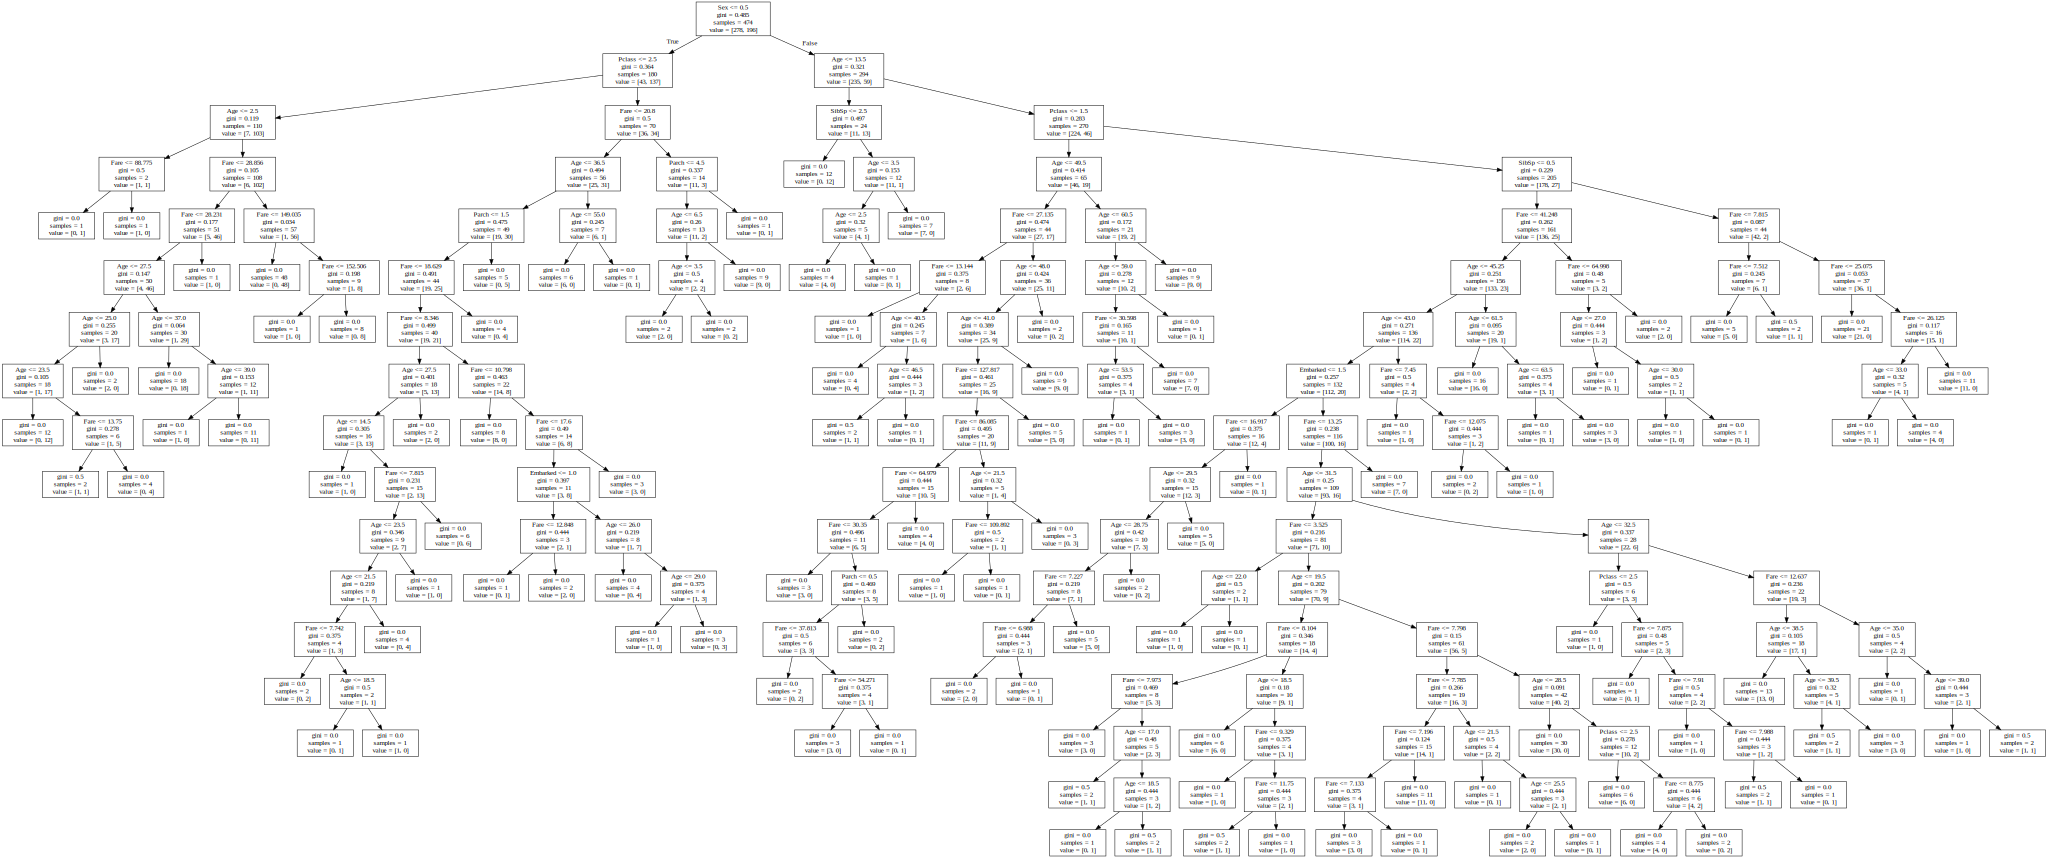

In [97]:
drawgraph(titanic_entropy_train_file)

score: 0.836134453782


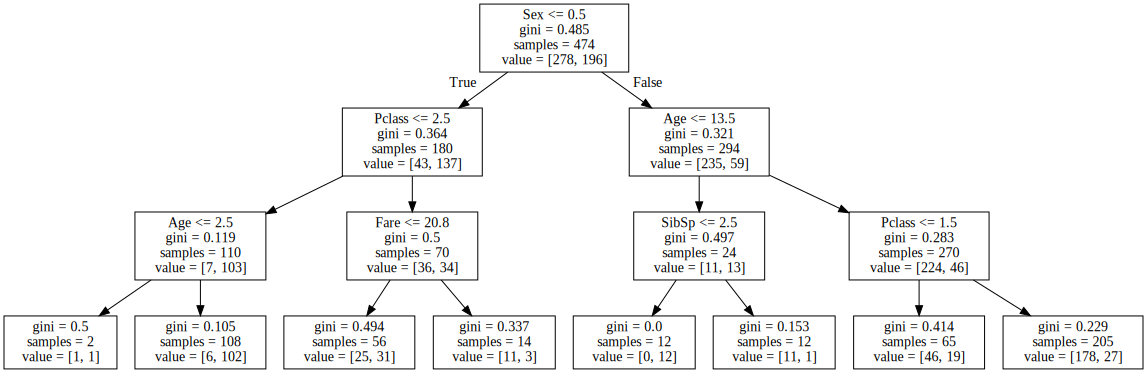

In [102]:
train_samples = len(titanic_X) * 2 / 3

titanic_entropy_train = tree.DecisionTreeClassifier(criterion='gini', max_depth=3)
titanic_entropy_train = titanic_entropy_train.fit(titanic_X[:train_samples], titanic_Y[:train_samples])

titanic_entropy_train_file = 'titanic_gini_train_short.dot'
with open(titanic_entropy_train_file, "w") as f:
    tree.export_graphviz(titanic_entropy_train, out_file=f, feature_names=titanic_X.columns)
    
print 'score:', titanic_entropy_train.score(titanic_X[train_samples:], titanic_Y[train_samples:])
drawgraph(titanic_entropy_train_file)

### cross-validation on titanic

In [106]:
print 'knn titanic acc:', 1.0 - cross_valid(titanic_X.as_matrix(), titanic_Y.as_matrix(), knn_model) / 10.0

knn titanic acc: 0.697183098592


In [125]:
def cross_valid_tree(X, Y, tree):
    n = len(Y)
    step = n / 10
    
    total_acc = 0

    for i in xrange(0, 10):
        t = tree.fit(pd.concat([X[:i * step], X[(i + 1) * step:]]), pd.concat([Y[:i * step], Y[(i + 1) * step:]]))
        total_acc += t.score(X[i*step : (i+1) * step], Y[i*step : (i+1) * step])
    
    return total_acc

In [136]:
print 'tree-gini titanic acc:', cross_valid_tree(titanic_X, titanic_Y,  tree.DecisionTreeClassifier(criterion='gini')) / 10.0
print 'tree-entropy titanic acc:', cross_valid_tree(titanic_X, titanic_Y,  tree.DecisionTreeClassifier(criterion='entropy')) / 10.0
print 'tree-gini max-depth3 titanic:', cross_valid_tree(titanic_X, titanic_Y,  tree.DecisionTreeClassifier(criterion='gini', max_depth=3)) / 10.0
print 'tree-entropy max-depth3 titanic acc:', cross_valid_tree(titanic_X, titanic_Y,  tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)) / 10.0


tree-gini titanic acc: 0.769014084507
tree-entropy titanic acc: 0.780281690141
tree-gini max-depth3 titanic: 0.801408450704
tree-entropy max-depth3 titanic acc: 0.797183098592


## Task 3

In [141]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [142]:
clf = RandomForestClassifier()

indxs = np.array(range(0, len(iris.data)))
np.random.shuffle(indxs)

clf = clf.fit(iris.data[indxs[:100]], iris.target[indxs[:100]])
clf.score(iris.data[indxs[100:150]], iris.target[indxs[100:150]])

0.93999999999999995

In [144]:
clf = RandomForestClassifier()

train_samples = len(titanic_X) * 2 / 3

clf = clf.fit(titanic_X[:train_samples], titanic_Y[:train_samples])
clf.score(titanic_X[train_samples:], titanic_Y[train_samples:])

0.78991596638655459

In [143]:
clf = ExtraTreesClassifier()

indxs = np.array(range(0, len(iris.data)))
np.random.shuffle(indxs)

clf = clf.fit(iris.data[indxs[:100]], iris.target[indxs[:100]])
clf.score(iris.data[indxs[100:150]], iris.target[indxs[100:150]])

0.95999999999999996

In [145]:
clf = ExtraTreesClassifier()

train_samples = len(titanic_X) * 2 / 3

clf = clf.fit(titanic_X[:train_samples], titanic_Y[:train_samples])
clf.score(titanic_X[train_samples:], titanic_Y[train_samples:])

0.76470588235294112

## Task 4: Mushroom data

In [180]:
mushroom_data = pd.read_csv('agaricus-lepiota.data', delimiter=',') \
                  .sample(frac=1.0) \
                  .reset_index(drop=True)
print mushroom_data        
for cat in list(mushroom_data):
    mushroom_data[cat] =  pd.Categorical(mushroom_data[cat]).codes
    
mushroom_data

      p  x  s  n  t p.1  f  c n.1  k ... s.2  w w.1 p.2 w.2  o p.3 k.1 s.3  u
0     p  f  y  e  f   y  f  c   n  b ...   s  p   w   p   w  o   e   w   v  p
1     p  f  f  y  f   f  f  c   b  g ...   k  p   n   p   w  o   l   h   y  p
2     p  f  s  n  f   s  f  c   n  b ...   s  p   w   p   w  o   e   w   v  l
3     e  f  y  e  t   n  f  c   b  p ...   s  p   w   p   w  o   p   n   v  d
4     p  x  y  n  f   f  f  c   n  b ...   k  p   w   p   w  o   e   w   v  d
5     p  x  y  g  f   f  f  c   b  p ...   k  p   n   p   w  o   l   h   v  g
6     e  b  s  w  t   l  f  c   b  w ...   s  w   w   p   w  o   p   n   n  g
7     p  x  s  b  t   f  f  c   b  p ...   f  w   w   p   w  o   p   h   v  u
8     p  x  y  g  f   f  f  c   b  p ...   k  p   b   p   w  o   l   h   v  g
9     p  x  f  g  f   f  f  c   b  p ...   k  b   n   p   w  o   l   h   y  g
10    p  f  y  n  f   s  f  c   n  b ...   s  p   w   p   w  o   e   w   v  l
11    p  f  s  e  f   y  f  c   n  b ...   s  w   w   p   w  o  

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,1,2,3,2,0,8,1,0,1,0,...,2,6,7,0,2,1,0,7,4,4
1,1,2,0,9,0,2,1,0,0,2,...,1,6,4,0,2,1,2,1,5,4
2,1,2,2,4,0,7,1,0,1,0,...,2,6,7,0,2,1,0,7,4,2
3,0,2,3,2,1,5,1,0,0,7,...,2,6,7,0,2,1,4,3,4,0
4,1,5,3,4,0,2,1,0,1,0,...,1,6,7,0,2,1,0,7,4,0
5,1,5,3,3,0,2,1,0,0,7,...,1,6,4,0,2,1,2,1,4,1
6,0,0,2,8,1,3,1,0,0,10,...,2,7,7,0,2,1,4,3,2,1
7,1,5,2,0,1,2,1,0,0,7,...,0,7,7,0,2,1,4,1,4,5
8,1,5,3,3,0,2,1,0,0,7,...,1,6,0,0,2,1,2,1,4,1
9,1,5,0,3,0,2,1,0,0,7,...,1,0,4,0,2,1,2,1,5,1


In [167]:
mushroom_X = mushroom_data.drop('p', axis = 1)
mushroom_Y = mushroom_data['p']


print mushroom_X, mushroom_Y

      x  s  n  t  p.1  f  c  n.1   k  e ...  s.2  w  w.1  p.2  w.2  o  p.3  \
0     2  3  3  1    5  1  0    0  10  1 ...    2  6    6    0    2  1    4   
1     3  2  4  0    7  1  0    1   0  1 ...    1  7    6    0    2  1    0   
2     5  0  3  0    2  1  0    0   7  0 ...    1  4    4    0    2  1    2   
3     2  0  2  1    5  1  0    0   7  1 ...    2  7    7    0    2  1    4   
4     3  2  8  0    5  1  1    0  10  0 ...    1  7    7    0    2  2    4   
5     2  0  3  0    2  1  0    0   2  0 ...    1  4    0    0    2  1    2   
6     5  3  3  0    2  1  0    0   2  0 ...    1  0    4    0    2  1    2   
7     2  2  9  1    3  1  1    1   5  1 ...    2  7    7    0    2  1    4   
8     0  3  9  1    0  1  0    0   2  0 ...    2  7    7    0    2  1    4   
9     2  0  8  1    3  1  1    1   7  1 ...    2  7    7    0    2  1    4   
10    5  3  4  0    7  1  0    1   0  1 ...    2  7    7    0    2  1    0   
11    5  0  8  0    1  1  1    1   2  0 ...    2  7    7    0   

In [174]:
clf = RandomForestClassifier()

train_samples = len(mushroom_X) * 2 / 3

print len(mushroom_X), train_samples

clf = clf.fit(mushroom_X[:train_samples], mushroom_Y[:train_samples])
clf.score(mushroom_X[train_samples:], mushroom_Y[train_samples:])

8123 5415


1.0

## Task 5: Car Evaluation

In [179]:
car_data = pd.read_csv('car.data', delimiter=',') \
             .sample(frac=1.0) \
             .reset_index(drop=True)
        
print car_data

for cat in list(car_data):
    car_data[cat] =  pd.Categorical(car_data[cat]).codes
    
car_data

      vhigh vhigh.1      2   2.1  small   low  unacc
0       med     low      2     4    big   low  unacc
1      high     low  5more  more    big   med    acc
2     vhigh     low      2     4    big   med    acc
3     vhigh     low      2     2    big  high  unacc
4      high     med  5more     2  small   low  unacc
5       low     med  5more     2  small   low  unacc
6      high     low      4     2  small  high  unacc
7       low     med      4     2  small   low  unacc
8     vhigh     med      3     4    big   low  unacc
9       low   vhigh      2     2    med  high  unacc
10    vhigh     med      3  more    med   med    acc
11      med     med      4  more    big   med    acc
12      low     low  5more     2    med  high  unacc
13     high     med  5more     2    med  high  unacc
14      low     med      3     4    big  high  vgood
15      low    high      3  more    big   low  unacc
16      med   vhigh      3     4  small   low  unacc
17    vhigh     med      3     2    big   low 

,vhigh,vhigh.1,2,2.1,small,low,unacc
0,2,1,0,1,0,1,2
1,0,1,3,2,0,2,0
2,3,1,0,1,0,2,0
3,3,1,0,0,0,0,2
4,0,2,3,0,2,1,2
5,1,2,3,0,2,1,2
6,0,1,2,0,2,0,2
7,1,2,2,0,2,1,2
8,3,2,1,1,0,1,2
9,1,3,0,0,1,0,2


In [181]:
car_X = car_data.drop('unacc', axis = 1)
car_Y = car_data['unacc']


print car_X, car_Y

      vhigh  vhigh.1  2  2.1  small  low
0         2        1  0    1      0    1
1         0        1  3    2      0    2
2         3        1  0    1      0    2
3         3        1  0    0      0    0
4         0        2  3    0      2    1
5         1        2  3    0      2    1
6         0        1  2    0      2    0
7         1        2  2    0      2    1
8         3        2  1    1      0    1
9         1        3  0    0      1    0
10        3        2  1    2      1    2
11        2        2  2    2      0    2
12        1        1  3    0      1    0
13        0        2  3    0      1    0
14        1        2  1    1      0    0
15        1        0  1    2      0    1
16        2        3  1    1      2    1
17        3        2  1    0      0    1
18        3        0  0    2      2    0
19        1        3  3    2      0    1
20        3        3  1    1      2    2
21        2        0  3    0      2    2
22        2        3  2    0      2    0
23        0     

In [196]:
clf = RandomForestClassifier()

train_samples = len(car_data) * 2 / 3

print len(mushroom_X), train_samples

clf = clf.fit(car_X[:train_samples], car_Y[:train_samples])
clf.score(car_X[train_samples:], car_Y[train_samples:])

8123 1151


0.953125

In [ ]:
## Task 6: